Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

Logistic regression 
--------

In [5]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits)) + 0.005*tf.nn.l2_loss(weights)
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [6]:
num_steps = 801

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.

    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 31.238466
Training accuracy: 10.0%
Validation accuracy: 12.9%
Loss at step 100: 10.268067
Training accuracy: 72.7%
Validation accuracy: 71.6%
Loss at step 200: 6.104387
Training accuracy: 76.1%
Validation accuracy: 74.5%
Loss at step 300: 3.757077
Training accuracy: 78.8%
Validation accuracy: 76.5%
Loss at step 400: 2.424228
Training accuracy: 81.0%
Validation accuracy: 78.3%
Loss at step 500: 1.666318
Training accuracy: 82.6%
Validation accuracy: 79.6%
Loss at step 600: 1.233261
Training accuracy: 83.6%
Validation accuracy: 80.7%
Loss at step 700: 0.984165
Training accuracy: 84.2%
Validation accuracy: 81.2%
Loss at step 800: 0.839969
Training accuracy: 84.6%
Validation accuracy: 81.7%
Test accuracy: 88.2%


Neural network
--------

#### light version 


In [7]:
batch_size = 128
hidden_layers_size = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    weights = tf.Variable(tf.truncated_normal([hidden_layers_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    hidden_weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layers_size]))
    hidden_biases = tf.Variable(tf.truncated_normal([hidden_layers_size]))
    
    logit_hidden = tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases
    
    logit = tf.matmul(tf.nn.relu(logit_hidden), weights) + biases

    # Training computation.
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logit)) \
            + 0.01*tf.nn.l2_loss(weights) + 0.01*tf.nn.l2_loss(hidden_weights) 

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logit)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases), weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases), weights) + biases)


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


Initialized
Minibatch loss at step 0: 3484.477295
Minibatch accuracy: 10.2%
Validation accuracy: 24.5%
Minibatch loss at step 500: 1152.567139
Minibatch accuracy: 81.2%
Validation accuracy: 80.8%
Minibatch loss at step 1000: 420.430786
Minibatch accuracy: 83.6%
Validation accuracy: 82.6%
Minibatch loss at step 1500: 154.686310
Minibatch accuracy: 78.1%
Validation accuracy: 83.9%
Minibatch loss at step 2000: 56.943432
Minibatch accuracy: 89.8%
Validation accuracy: 86.0%
Minibatch loss at step 2500: 21.456387
Minibatch accuracy: 82.0%
Validation accuracy: 85.7%
Minibatch loss at step 3000: 8.307608
Minibatch accuracy: 86.7%
Validation accuracy: 85.0%
Test accuracy: 90.9%


#### heavy version 

In [9]:
batch_size = 128
hidden_layers_size = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    input_weights = tf.Variable(tf.truncated_normal([image_size * image_size, batch_size]))
    input_biases = tf.Variable(tf.truncated_normal([batch_size]))
     
    hidden_weights = tf.Variable(tf.truncated_normal([batch_size, hidden_layers_size]))
    hidden_biases = tf.Variable(tf.truncated_normal([hidden_layers_size]))
    
    output_weights = tf.Variable(tf.truncated_normal([hidden_layers_size, num_labels]))
    output_biases = tf.Variable(tf.zeros([num_labels]))

    
    def network(input): 
        logit_input = tf.matmul(input, input_weights) + input_biases
        logit_hidden = tf.matmul(tf.nn.relu(logit_input), hidden_weights) + hidden_biases    
        logit_output = tf.matmul(logit_hidden, output_weights) + output_biases
        
        return logit_output + 0.01*tf.nn.l2_loss(input_weights) + 0.01*tf.nn.l2_loss(hidden_weights) \
                + 0.01*tf.nn.l2_loss(output_weights)

    # Training computation.
    predictions = network(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=predictions))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.0001).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(predictions)
    valid_prediction = tf.nn.softmax(network(tf_valid_dataset))
    test_prediction = tf.nn.softmax(network(tf_test_dataset))

num_steps = 30001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

    

Initialized
Minibatch loss at step 0: 4387.492676
Minibatch accuracy: 5.5%
Validation accuracy: 5.5%
Minibatch loss at step 500: 460.699829
Minibatch accuracy: 64.8%
Validation accuracy: 61.5%
Minibatch loss at step 1000: 373.021149
Minibatch accuracy: 68.0%
Validation accuracy: 67.6%
Minibatch loss at step 1500: 446.565002
Minibatch accuracy: 68.0%
Validation accuracy: 70.1%
Minibatch loss at step 2000: 193.107117
Minibatch accuracy: 76.6%
Validation accuracy: 71.7%
Minibatch loss at step 2500: 281.370239
Minibatch accuracy: 70.3%
Validation accuracy: 72.3%
Minibatch loss at step 3000: 224.408997
Minibatch accuracy: 75.0%
Validation accuracy: 72.9%
Minibatch loss at step 3500: 242.409576
Minibatch accuracy: 71.1%
Validation accuracy: 73.3%
Minibatch loss at step 4000: 206.336792
Minibatch accuracy: 69.5%
Validation accuracy: 74.2%
Minibatch loss at step 4500: 100.002655
Minibatch accuracy: 80.5%
Validation accuracy: 74.5%
Minibatch loss at step 5000: 143.100403
Minibatch accuracy: 78.

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [10]:
print(train_dataset.shape)
print(train_labels.shape)
train_dataset1 = train_dataset[:256, :]
train_labels1 = train_labels[:256, :]
print(train_dataset1.shape)
print(train_labels.shape)


batch_size = 128
hidden_layers_size = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    weights = tf.Variable(tf.truncated_normal([hidden_layers_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    hidden_weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layers_size]))
    hidden_biases = tf.Variable(tf.truncated_normal([hidden_layers_size]))
    
    logit_hidden = tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases
    
    logit = tf.matmul(tf.nn.relu(logit_hidden), weights) + biases

    # Training computation.
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logit)) \
            + 0.01*tf.nn.l2_loss(weights) + 0.01*tf.nn.l2_loss(hidden_weights) 

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logit)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases), weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases), weights) + biases)

    
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels1.shape[0] - batch_size)

        # Generate a minibatch.
        batch_data = train_dataset1[offset:(offset + batch_size), :]
        batch_labels = train_labels1[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

(200000, 784)
(200000, 10)
(256, 784)
(200000, 10)
Initialized
Minibatch loss at step 0: 3574.677246
Minibatch accuracy: 4.7%
Validation accuracy: 24.5%
Minibatch loss at step 500: 1158.654785
Minibatch accuracy: 100.0%
Validation accuracy: 55.1%
Minibatch loss at step 1000: 426.032745
Minibatch accuracy: 100.0%
Validation accuracy: 54.7%
Minibatch loss at step 1500: 156.652832
Minibatch accuracy: 100.0%
Validation accuracy: 54.8%
Minibatch loss at step 2000: 57.615635
Minibatch accuracy: 100.0%
Validation accuracy: 59.2%
Minibatch loss at step 2500: 21.237299
Minibatch accuracy: 100.0%
Validation accuracy: 66.7%
Minibatch loss at step 3000: 7.899362
Minibatch accuracy: 100.0%
Validation accuracy: 68.7%
Test accuracy: 75.0%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

#### Normal case 

In [11]:
batch_size = 128
hidden_layers_size = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    weights = tf.Variable(tf.truncated_normal([hidden_layers_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    hidden_weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layers_size]))
    hidden_biases = tf.Variable(tf.truncated_normal([hidden_layers_size]))
    
    logit_hidden = tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases
    
    logit = tf.matmul(tf.nn.dropout(tf.nn.relu(logit_hidden), 0.5), weights) + biases

    # Training computation.
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logit)) \
            + 0.01*tf.nn.l2_loss(weights) + 0.01*tf.nn.l2_loss(hidden_weights) 

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logit)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases), weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases), weights) + biases)

    
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
    

Initialized
Minibatch loss at step 0: 3619.852051
Minibatch accuracy: 7.8%
Validation accuracy: 24.2%
Minibatch loss at step 500: 1153.475342
Minibatch accuracy: 75.8%
Validation accuracy: 83.4%
Minibatch loss at step 1000: 418.912567
Minibatch accuracy: 72.7%
Validation accuracy: 83.5%
Minibatch loss at step 1500: 153.796844
Minibatch accuracy: 77.3%
Validation accuracy: 84.7%
Minibatch loss at step 2000: 56.797161
Minibatch accuracy: 85.2%
Validation accuracy: 84.6%
Minibatch loss at step 2500: 21.399641
Minibatch accuracy: 78.1%
Validation accuracy: 84.7%
Minibatch loss at step 3000: 8.322268
Minibatch accuracy: 84.4%
Validation accuracy: 84.5%
Test accuracy: 90.3%


#### Overfitting case 

In [12]:
print(train_dataset.shape)
print(train_labels.shape)
train_dataset1 = train_dataset[:256, :]
train_labels1 = train_labels[:256, :]
print(train_dataset1.shape)
print(train_labels.shape)


batch_size = 128
hidden_layers_size = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    weights = tf.Variable(tf.truncated_normal([hidden_layers_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    hidden_weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layers_size]))
    hidden_biases = tf.Variable(tf.truncated_normal([hidden_layers_size]))
    
    logit_hidden = tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases
    
    logit = tf.matmul(tf.nn.relu(tf.nn.dropout(logit_hidden, 0.8)), weights) + biases

    # Training computation.
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logit)) \
            + 0.01*tf.nn.l2_loss(weights) + 0.01*tf.nn.l2_loss(hidden_weights) 

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logit)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases), weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases), weights) + biases)

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels1.shape[0] - batch_size)

        # Generate a minibatch.
        batch_data = train_dataset1[offset:(offset + batch_size), :]
        batch_labels = train_labels1[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
            print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

(200000, 784)
(200000, 10)
(256, 784)
(200000, 10)
Initialized
Minibatch loss at step 0: 3516.660645
Minibatch accuracy: 9.4%
Validation accuracy: 31.7%
Minibatch loss at step 500: 1156.660522
Minibatch accuracy: 100.0%
Validation accuracy: 61.7%
Minibatch loss at step 1000: 425.300964
Minibatch accuracy: 100.0%
Validation accuracy: 63.8%
Minibatch loss at step 1500: 156.383896
Minibatch accuracy: 100.0%
Validation accuracy: 63.9%
Minibatch loss at step 2000: 57.513275
Minibatch accuracy: 100.0%
Validation accuracy: 65.2%
Minibatch loss at step 2500: 21.190153
Minibatch accuracy: 100.0%
Validation accuracy: 67.8%
Minibatch loss at step 3000: 7.892344
Minibatch accuracy: 100.0%
Validation accuracy: 69.5%
Test accuracy: 75.8%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


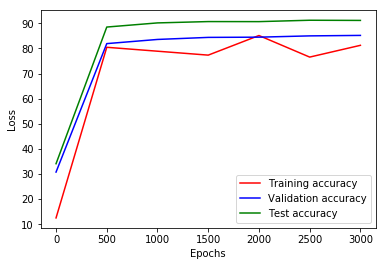

None

Test accuracy: 91.2%


In [68]:
import math 

batch_size = 128
hidden_layers_size = 1024
learning_starting_rate = 0.1
learning_decay_steps = 100
learning_decay_rate = 0.95
beta = 1*10^-5
keep_prob_dropouts=0.8

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    weights = tf.Variable(tf.truncated_normal([hidden_layers_size, num_labels]))
#     weights = tf.Variable(tf.truncated_normal([hidden_layers_size, num_labels], stddev=1 / math.sqrt(float(image_size * image_size))))
    biases = tf.Variable(tf.zeros([num_labels]))
    
    hidden_weights = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layers_size]))
    hidden_biases = tf.Variable(tf.truncated_normal([hidden_layers_size]))
    
    logit_hidden = tf.matmul(tf_train_dataset, hidden_weights) + hidden_biases
    
    logit = tf.matmul(tf.nn.dropout(tf.nn.relu(logit_hidden), keep_prob_dropouts), weights) + biases

    # Training computation.
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logit)) #\
            #+ beta*tf.nn.l2_loss(weights) + beta*tf.nn.l2_loss(hidden_weights) 

    # Optimizer.
#     optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
    
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(learning_starting_rate, global_step, learning_decay_steps, learning_decay_rate)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logit)
    valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, hidden_weights) + hidden_biases), weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, hidden_weights) + hidden_biases), weights) + biases)


import matplotlib.pyplot as plt 
from IPython import display

train_acc_history = []
val_acc_history = []
test_acc_history = []
epochs_history = []

num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels }
        _, l, predictions, lr = session.run([optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Offset: %d" % offset )
            print("Learning rate: %f" % lr )            
            print("Minibatch loss at step %d: %f" % (step, l))
            train_acc = accuracy(predictions, batch_labels)
            print("Minibatch accuracy: %.1f%%" % train_acc)
            val_acc = accuracy(valid_prediction.eval(), valid_labels)
            print("Validation accuracy: %.1f%%" % val_acc)
            test_acc = accuracy(test_prediction.eval(), test_labels)

            display.clear_output(wait=True)            
            epochs_history.append(step)
            train_acc_history.append(train_acc)
            val_acc_history.append(val_acc)
            test_acc_history.append(test_acc)
            
            def print(x, ys): 
                for(y in ys): 
                    plt.plot(epochs_history, train_acc_history, 'r', label='Training accuracy')
                    plt.plot(epochs_history, val_acc_history, 'b', label='Validation accuracy')
                    plt.plot(epochs_history, test_acc_history, 'g', label='Test accuracy')            
                    plt.xlabel('Epochs')
                    plt.ylabel('Accuracy')
                    plt.legend()
            
            display.display(plt.show())
                     
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


#### Deeper network

Initialized
Learning rate: 0.010000
Minibatch loss at step 0: 23812.347656
Minibatch accuracy: 9.0%
Validation accuracy: 36.5%


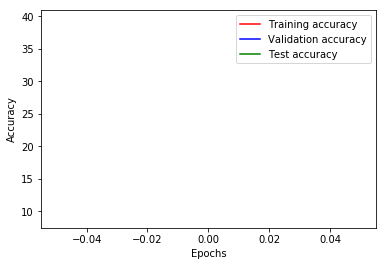

Learning rate: 0.009747
Minibatch loss at step 500: 323.333252
Minibatch accuracy: 82.5%
Validation accuracy: 80.3%


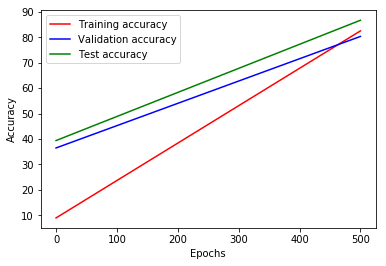

Learning rate: 0.009500
Minibatch loss at step 1000: 374.299011
Minibatch accuracy: 78.4%
Validation accuracy: 79.5%


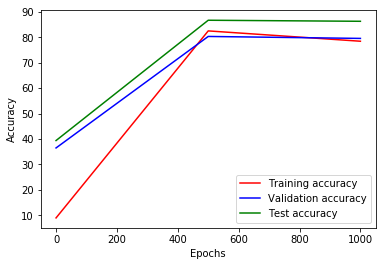

Learning rate: 0.009259
Minibatch loss at step 1500: 138.092331
Minibatch accuracy: 82.9%
Validation accuracy: 81.9%


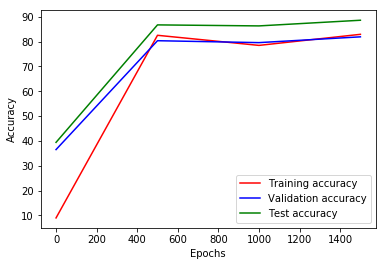

Learning rate: 0.009025
Minibatch loss at step 2000: 119.029221
Minibatch accuracy: 83.0%
Validation accuracy: 81.5%


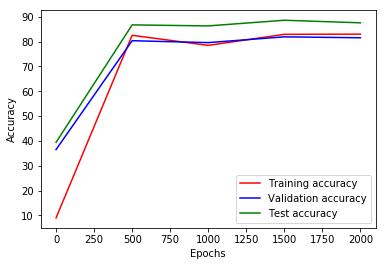

Learning rate: 0.008796
Minibatch loss at step 2500: 109.189392
Minibatch accuracy: 81.6%
Validation accuracy: 81.5%


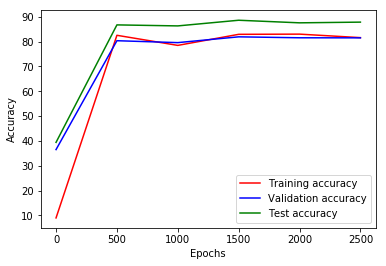

Learning rate: 0.008574
Minibatch loss at step 3000: 98.955933
Minibatch accuracy: 80.5%
Validation accuracy: 79.1%


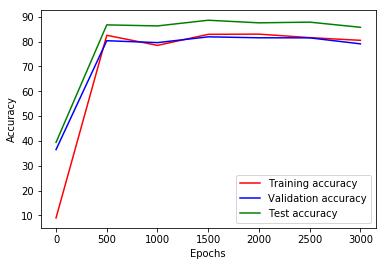

Learning rate: 0.008357
Minibatch loss at step 3500: 46.649040
Minibatch accuracy: 83.8%
Validation accuracy: 81.3%


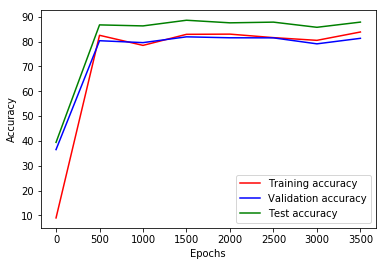

Learning rate: 0.008145
Minibatch loss at step 4000: 73.210426
Minibatch accuracy: 82.5%
Validation accuracy: 80.0%


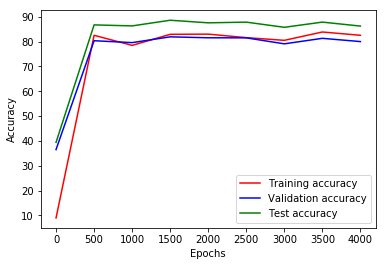

Learning rate: 0.007939
Minibatch loss at step 4500: 72.654068
Minibatch accuracy: 81.3%
Validation accuracy: 80.0%


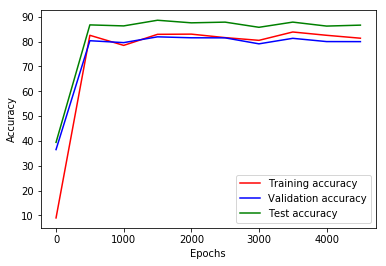

Learning rate: 0.007738
Minibatch loss at step 5000: 58.608727
Minibatch accuracy: 82.0%
Validation accuracy: 80.4%


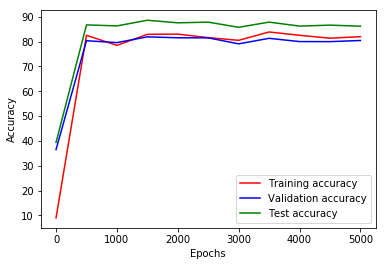

Learning rate: 0.007542
Minibatch loss at step 5500: 57.533161
Minibatch accuracy: 81.1%
Validation accuracy: 80.9%


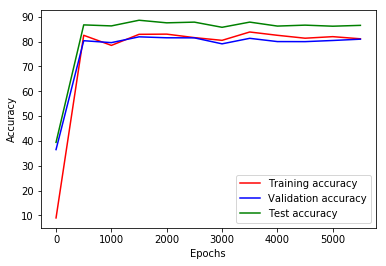

Learning rate: 0.007351
Minibatch loss at step 6000: 52.965405
Minibatch accuracy: 82.0%
Validation accuracy: 81.2%


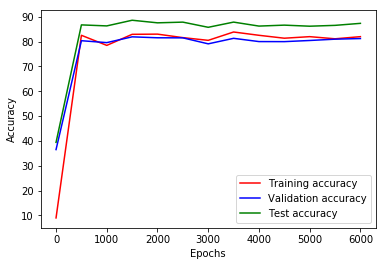

Learning rate: 0.007165
Minibatch loss at step 6500: 52.550892
Minibatch accuracy: 80.8%
Validation accuracy: 81.0%


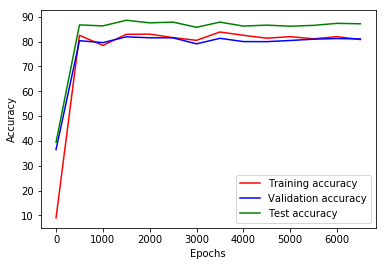

Learning rate: 0.006983
Minibatch loss at step 7000: 43.443420
Minibatch accuracy: 84.1%
Validation accuracy: 80.1%


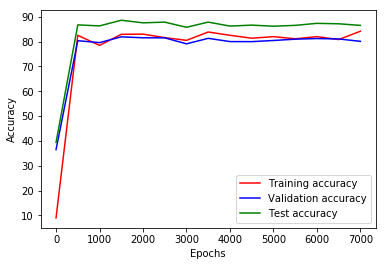

Learning rate: 0.006807
Minibatch loss at step 7500: 45.527443
Minibatch accuracy: 81.8%
Validation accuracy: 80.3%


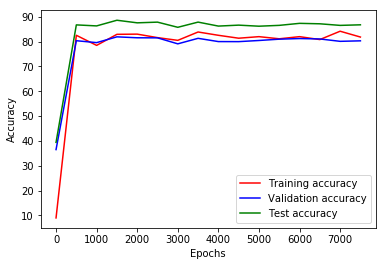

Learning rate: 0.006634
Minibatch loss at step 8000: 33.077549
Minibatch accuracy: 83.0%
Validation accuracy: 81.3%


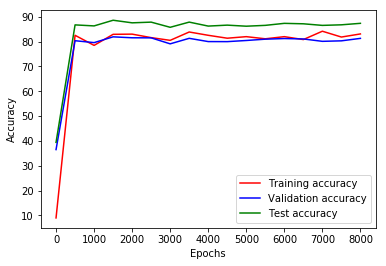

Learning rate: 0.006466
Minibatch loss at step 8500: 55.448009
Minibatch accuracy: 83.0%
Validation accuracy: 81.2%


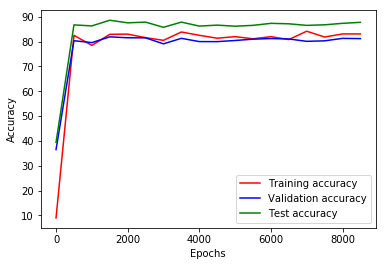

Learning rate: 0.006302
Minibatch loss at step 9000: 47.124767
Minibatch accuracy: 81.1%
Validation accuracy: 80.8%


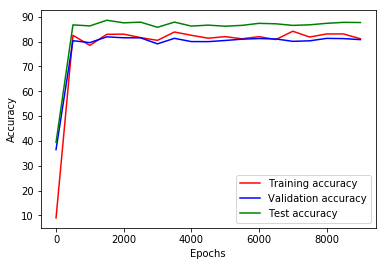

Learning rate: 0.006143
Minibatch loss at step 9500: 43.533810
Minibatch accuracy: 82.1%
Validation accuracy: 80.4%


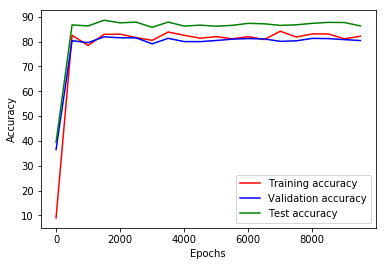

KeyboardInterrupt: 

In [73]:
batch_size = 1280
hidden_layers_size = 4096

learning_starting_rate = 0.01
learning_decay_steps = 1000
learning_decay_rate = 0.95
beta = 1*10^-5
keep_prob_dropouts=0.8

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,
                                      shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    input_weights = tf.Variable(tf.truncated_normal([image_size * image_size, batch_size]))
    input_biases = tf.Variable(tf.truncated_normal([batch_size]))
     
    hidden_weights = tf.Variable(tf.truncated_normal([batch_size, hidden_layers_size]))
    hidden_biases = tf.Variable(tf.truncated_normal([hidden_layers_size]))
    
    output_weights = tf.Variable(tf.truncated_normal([hidden_layers_size, num_labels]))
    output_biases = tf.Variable(tf.zeros([num_labels]))

    
    def network(input): 
        logit_input = tf.matmul(input, input_weights) + input_biases
        logit_hidden = tf.matmul(tf.nn.dropout(tf.nn.relu(logit_input), keep_prob_dropouts), hidden_weights) + hidden_biases    
        logit_output = tf.matmul(logit_hidden, output_weights) + output_biases
        
        return logit_output #+ 0.01*tf.nn.l2_loss(input_weights) + 0.01*tf.nn.l2_loss(hidden_weights) \
                #+ 0.01*tf.nn.l2_loss(output_weights)

    # Training computation.
    predictions = network(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=predictions))

    # Optimizer.
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(learning_starting_rate, global_step, learning_decay_steps, learning_decay_rate)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)


    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(predictions)
    valid_prediction = tf.nn.softmax(network(tf_valid_dataset))
    test_prediction = tf.nn.softmax(network(tf_test_dataset))


import matplotlib.pyplot as plt 
from IPython import display

train_acc_history = []
val_acc_history = []
test_acc_history = []
epochs_history = []
    
num_steps = 30001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions, lr = session.run([optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        
        if (step % 500 == 0):
            print("Learning rate: %f" % lr )       
            print("Minibatch loss at step %d: %f" % (step, l))
            train_acc = accuracy(predictions, batch_labels)
            print("Minibatch accuracy: %.1f%%" % train_acc)
            val_acc = accuracy(valid_prediction.eval(), valid_labels)
            print("Validation accuracy: %.1f%%" % val_acc)
            test_acc = accuracy(test_prediction.eval(), test_labels)
            
            
            #display.clear_output(wait=True)            
            epochs_history.append(step)
            train_acc_history.append(train_acc)
            val_acc_history.append(val_acc)
            test_acc_history.append(test_acc)
            

            plt.plot(epochs_history, train_acc_history, 'r', label='Training accuracy')
            plt.plot(epochs_history, val_acc_history, 'b', label='Validation accuracy')
            plt.plot(epochs_history, test_acc_history, 'g', label='Test accuracy')            
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            
            plt.show()
            #display.display(plt.show())

    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

    